## Problem statement

"Create a model that can predict the median house value as a function of the following inputs"

## Given data

CSV file with 20640 rows and 10 columns:
Longitude, Latitude, Housing median age, total rooms, total bedrooms, population, households, median income, **median house value**, ocean proximity


## Assumptions

- The data is current, i.e. it is not necessary to update the data externally
- Each data point represents a neighborhood  
- The model should be **constrained to California**
- I can use the median housing values to fit a model, but I cannot use it as an input. Therefore, the solution "find the 5 nearest neighborhoods and calculate the mean housing price as an approximate" is not valid

## Steps

1) Visualize the data
2) Clean data (e.g NaN values)
3) Analyze data and add features that might be useful
4) Create a baseline model - Polynomial regression
4) Build a more complex model - Feedforward NN (other options were also possible)
5) Assess the accuracy of the model
6) Build a simple function to perform predictions (add warning and errror messages)
7) Find shortcomings and potential areas of improvement 

### Note

This Jupyter notebook includes the training of neural networks, some parts were commented out, as the best performing one was selected. If desired, uncomment those parts and run the entire notebook

**IMPORTS**

In [268]:
# imports

import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import numpy as np
from haversine import haversine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
import os
from itertools import product
import pickle as pkl



## 1) Data visualization

In [269]:
CSV_FILE_PATH = 'housing.csv'

In [270]:
df = pd.read_csv(CSV_FILE_PATH)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [271]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


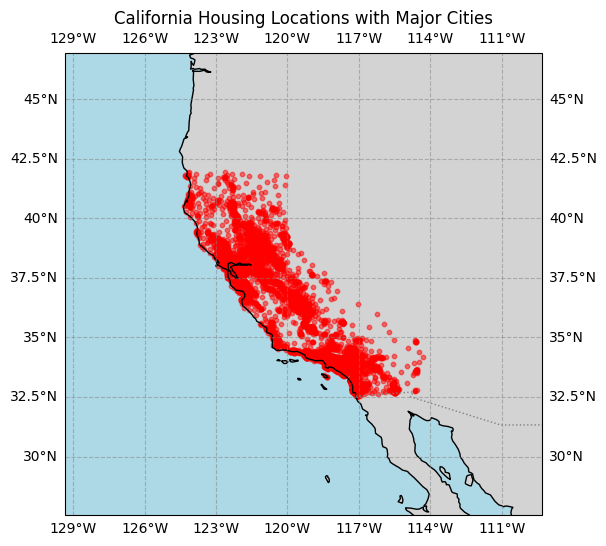

In [272]:
# Plot a map of California with housing locations

latitudes = df["latitude"]
longitudes = df["longitude"]

# Create a figure with a map projection
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Add map features (coastlines, borders, etc.)
ax.add_feature(cfeature.LAND, facecolor="lightgray")
ax.add_feature(cfeature.OCEAN, facecolor="lightblue")
ax.add_feature(cfeature.COASTLINE, edgecolor="black")
ax.add_feature(cfeature.BORDERS, linestyle=":", edgecolor="gray")

# Plot locations as scatter points
ax.scatter(
    longitudes,
    latitudes,
    color="red",
    s=10,
    transform=ccrs.PlateCarree(),
    alpha=0.5,
)

# Set map extent
ax.set_extent(
    [
        min(longitudes) - 5,
        max(longitudes) + 5,
        min(latitudes) - 5,
        max(latitudes) + 5,
    ],
    crs=ccrs.PlateCarree(),
)

# Add gridlines and labels
ax.gridlines(draw_labels=True, linestyle="--", color="gray", alpha=0.5)

plt.title("California Housing Locations with Major Cities")
plt.show()

In [273]:
# We will add the main cities to the plot
# City : (longitude, latitude)
cities = {
    "Los Angeles": (-118.24656793261641, 34.037090784879666),
    "San Francisco": (-122.43918138345337, 37.77329879839024),
    "San Jose": (-121.90024417128528, 37.337544797121964),
    "Sacramento": (-121.47617414836137, 38.57828572360444),
    "San Diego": (-117.12293338885459, 32.70280014523324),
}

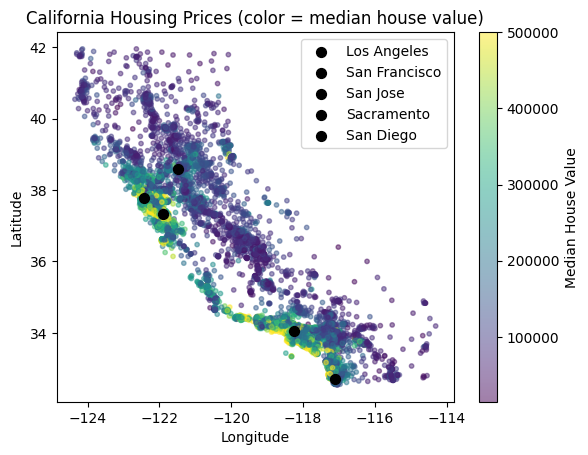

In [274]:
# Plotting the data with median house value as color and the main cities highlighted
plt.scatter(df["longitude"], df["latitude"], c=df["median_house_value"], cmap="viridis", s=10, alpha=0.5)
plt.colorbar(label="Median House Value")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("California Housing Prices (color = median house value)")
for city, (lon, lat) in cities.items():
    plt.scatter(lon, lat, color='black', label=city, s=50)
# To avoid duplicate labels in the legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.legend()
plt.show()

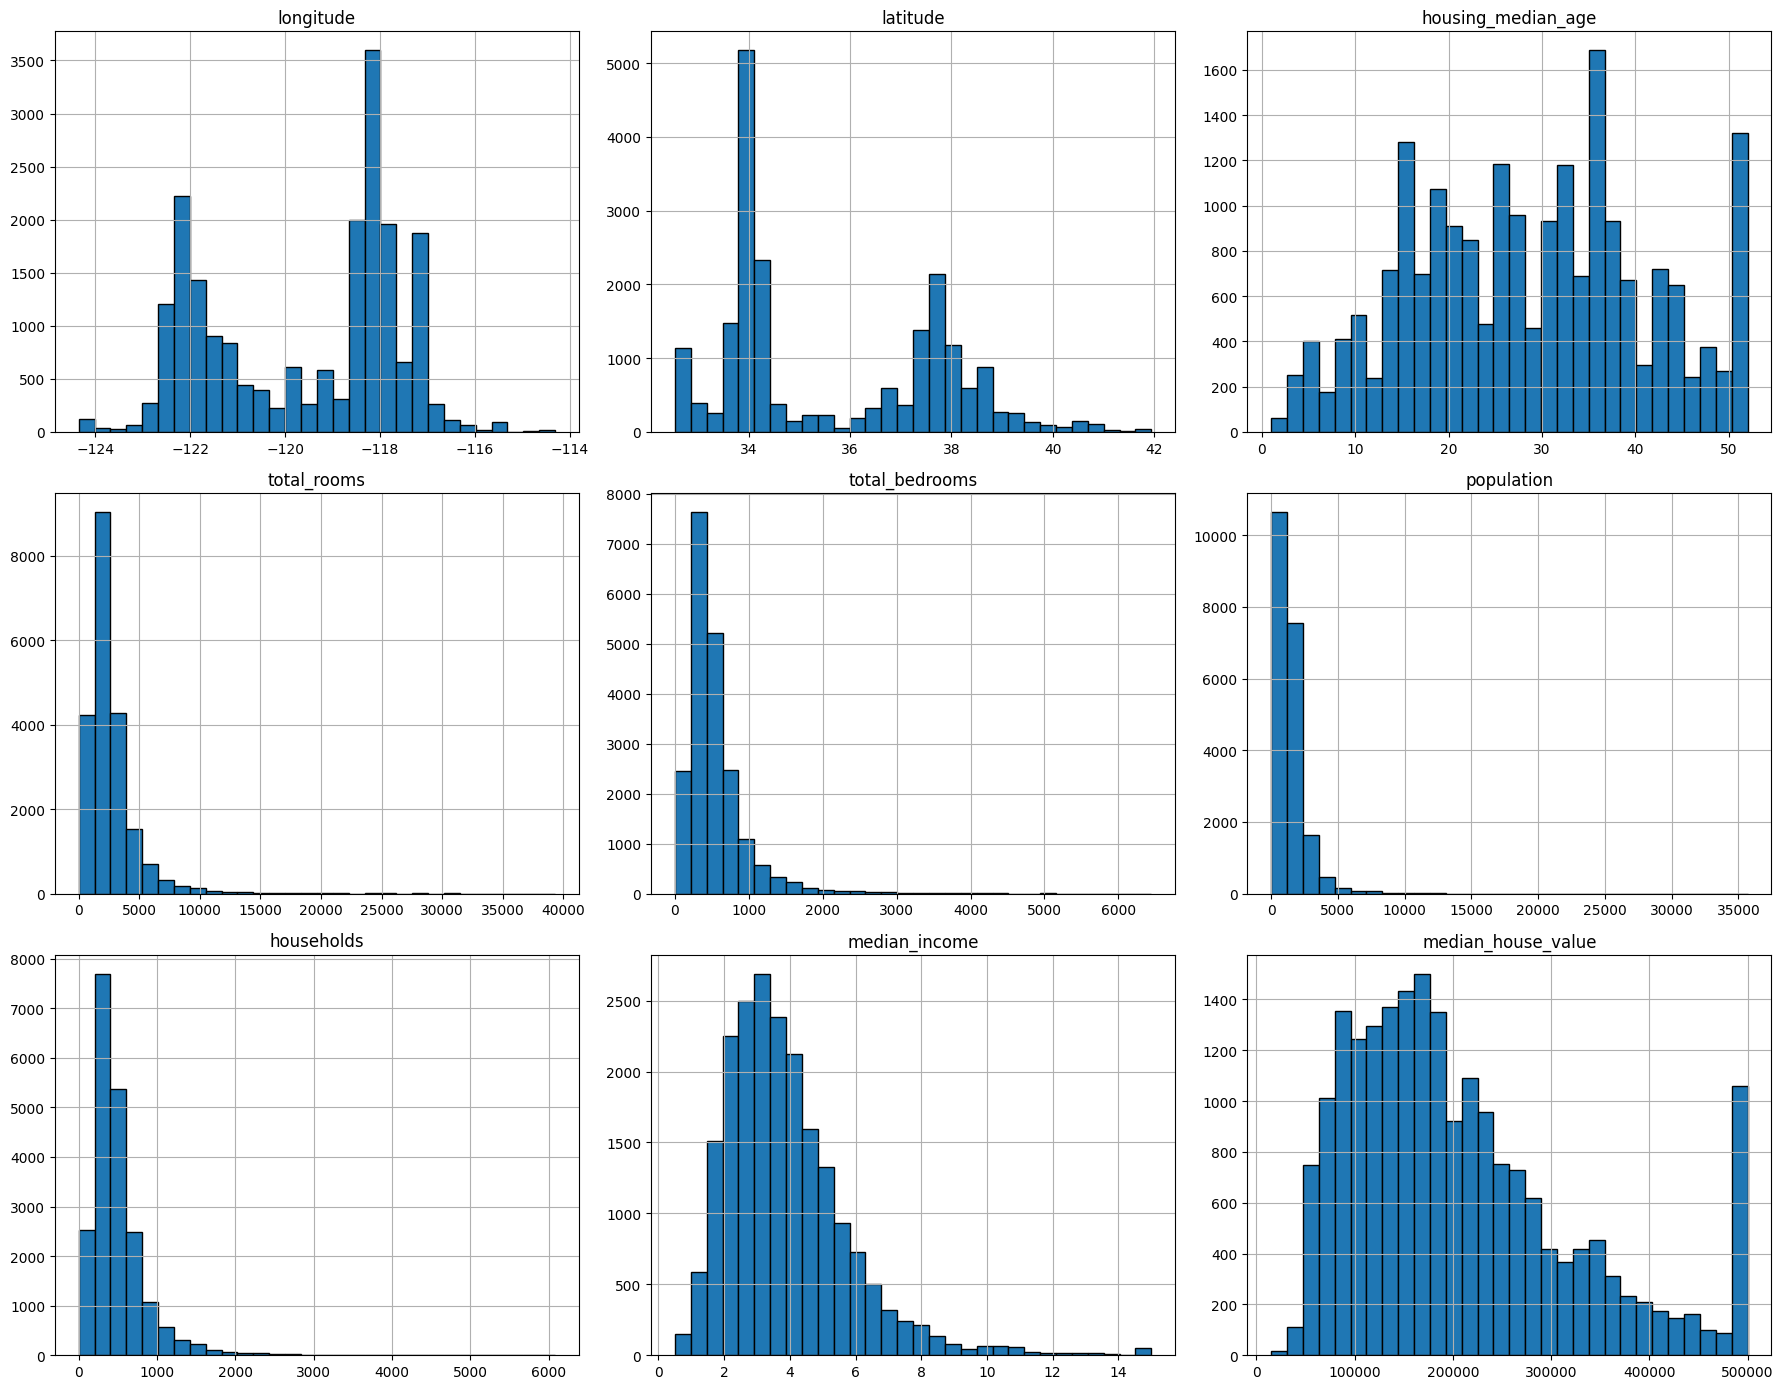

In [275]:
# Plot histograms of the numerical features
df.hist(figsize=(18, 14), bins=30, edgecolor='black')
plt.tight_layout()
plt.show()

### Section summary / Qualitative assessment of the data:
- It is expected to be a correlation between income and household value, also the neighborhoods near the beach should be more expensive than the ones far away from it
- Places near the major cities are more expensive
- The dataset seems to have disproportionately high number of houses with median house value at 500000. This might indicate that the dataset is capped at that range. We should expect the model to not perform optimally for those values

## 2) and 3) Data cleaning and adding features

In [276]:
nan_counts = df.isna().sum()
print("Number of NaN values in each column:\n", nan_counts)

Number of NaN values in each column:
 longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64


In [277]:
# Remove rows with NaN values in 'total_bedrooms' NOTE Other solutions possible
df = df[df["total_bedrooms"].notna()]

In [278]:
# Check for negative values in numeric columns
negative_values = (df.select_dtypes(include=["number"]) < 0).any()
print("Columns with negative values:\n", negative_values) 
# Longitude can be negative 

Columns with negative values:
 longitude              True
latitude              False
housing_median_age    False
total_rooms           False
total_bedrooms        False
population            False
households            False
median_income         False
median_house_value    False
dtype: bool


In [279]:
# Check for neighborhoods with very small or high median ages
#max_age = df["housing_median_age"].max()
#min_age = df["housing_median_age"].min()
#print("Max housing median age:", max_age)
#print("Min housing median age:", min_age)
#med_age_below_3 = df[df["housing_median_age"] <= 3]
#print("Number of rows where housing median age is below 3:", med_age_below_3.shape[0])
#med_age_below_3.head()
# Theoretically possible, so it will not be removed

In [280]:
# Remove rows with very small median ages
df = df[df["housing_median_age"] >= 3]

In [281]:
# Check for rows where total_bedrooms > total_rooms
invalid_bedrooms = df[df["total_bedrooms"] > df["total_rooms"]]
print("Rows where total_bedrooms > total_rooms:", invalid_bedrooms.shape[0])

Rows where total_bedrooms > total_rooms: 0


In [282]:
# Add new features
df["inhabitants_per_house"] = df["population"] / df["households"]
df["rooms_per_house"] = df["total_rooms"] / df["households"]
df["bedrooms_per_house"] = df["total_bedrooms"] / df["households"]
df["income_per_house"] = df["median_income"] / df["households"]

Check current state of the dataset

In [283]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,inhabitants_per_house,rooms_per_house,bedrooms_per_house,income_per_house
count,20371.000000,20371.000000,20371.000000,20371.000000,20371.000000,20371.000000,20371.000000,20371.000000,20371.000000,20371.000000,20371.000000,20371.000000,20371.000000
mean,-119.571990,35.633504,28.714349,2628.566541,536.872171,1423.288498,498.870993,3.867444,206826.554956,3.072421,5.424312,1.096471,0.015722
std,2.003189,2.136465,12.524373,2158.848229,418.332331,1128.497904,380.714698,1.897414,115442.631704,10.454081,2.477051,0.476356,0.119288
min,-124.350000,32.540000,3.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,0.692308,0.846154,0.333333,0.000380
25%,-121.800000,33.930000,18.000000,1450.000000,296.000000,788.000000,280.000000,2.562500,119400.000000,2.429086,4.439812,1.005897,0.005043
50%,-118.500000,34.260000,29.000000,2125.000000,435.000000,1166.000000,409.000000,3.533300,179700.000000,2.817490,5.227504,1.048762,0.008446
75%,-118.010000,37.720000,37.000000,3138.500000,646.000000,1721.000000,603.000000,4.740100,264700.000000,3.282239,6.047351,1.099119,0.014100
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,1243.333333,141.909091,34.066667,15.000100


In [284]:
# Optional: Remove rows with extremely high number of rooms or bedrooms
# Note: Removing these rows takes away the rows in the island

# Remove rows where total rooms is higher than 100
#df = df[df["total_rooms"] <= 100]
# Remove rows where bedrooms per house is higher than 30
#df = df[df["bedrooms_per_house"] <= 30]


Convert ocean proximity from string to numerical values - ordinal classification selected

In [285]:
unique_ocean_proximity = df["ocean_proximity"].unique()
print(unique_ocean_proximity)

['NEAR BAY' '<1H OCEAN' 'INLAND' 'NEAR OCEAN' 'ISLAND']


Mean median house value for 'INLAND': 124638.83310109924
Mean median house value for '<1H OCEAN': 240102.8869661675
Mean median house value for 'NEAR OCEAN': 249089.98819497335
Mean median house value for 'NEAR BAY': 259347.52559576347
Mean median house value for 'ISLAND': 380440.0


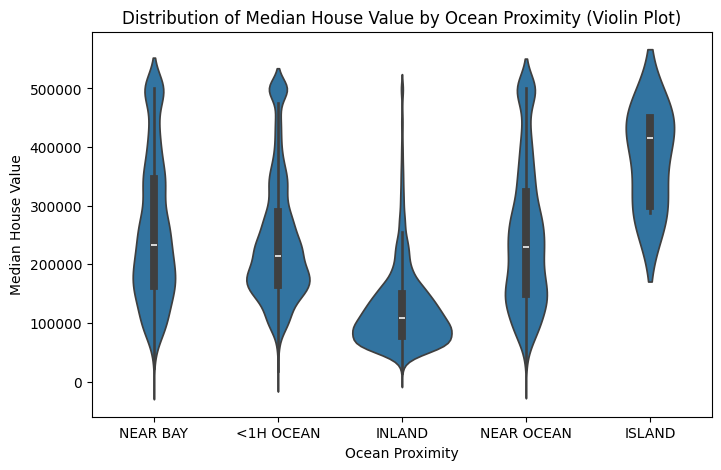

In [286]:
proximity_descriptors_list = [
    "INLAND",
    "<1H OCEAN",
    "NEAR OCEAN",
    "NEAR BAY",
    "ISLAND"
]
avg_price_by_proximity = df.groupby("ocean_proximity")["median_house_value"].mean()
for item in proximity_descriptors_list:
    print(f"Mean median house value for '{item}': {avg_price_by_proximity.get(item)}")

plt.figure(figsize=(8, 5))
sns.violinplot(x="ocean_proximity", y="median_house_value", data=df)
plt.xlabel("Ocean Proximity")
plt.ylabel("Median House Value")
plt.title("Distribution of Median House Value by Ocean Proximity (Violin Plot)")
plt.show()

In [287]:
# We use ordinal values for ocean proximity based on average median house values
proximity_map = {
    "INLAND": 0,
    "<1H OCEAN": 0.25, 
    "NEAR OCEAN": 0.5,
    "NEAR BAY": 0.75,
    "ISLAND": 1
}

df["ocean_proximity"] = df["ocean_proximity"].map(proximity_map)

In [288]:
# Check if the mapping worked
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,inhabitants_per_house,rooms_per_house,bedrooms_per_house,income_per_house
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0.75,2.555556,6.984127,1.023810,0.066073
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0.75,2.109842,6.238137,0.971880,0.007295
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0.75,2.802260,8.288136,1.073446,0.041002
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0.75,2.547945,5.817352,1.073059,0.025768
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0.75,2.181467,6.281853,1.081081,0.014850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,0.00,2.560606,5.045455,1.133333,0.004728
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,0.00,3.122807,6.114035,1.315789,0.022428
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,0.00,2.325635,5.205543,1.120092,0.003926
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,0.00,2.123209,5.329513,1.171920,0.005350


We calculate the distance to all major cities and to the closest one using the haversine formula
Haversine formula more accurate for distance calculation on a sphere
Reference: https://en.wikipedia.org/wiki/Haversine_formula

In [289]:
for city, (lon, lat) in cities.items():
    df[f"distance_to_{city}"] = df.apply(
        lambda row: haversine((row["latitude"], row["longitude"]), (lat, lon)), axis=1
    )
df["distance_to_closest_city"] = df[[f"distance_to_{city}" for city in cities.keys()]].min(axis=1)

In [290]:
# Drop the individual distance columns to keep only the closest city distance
df = df.drop(columns=[f"distance_to_{city}" for city in cities.keys()])

In [291]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,inhabitants_per_house,rooms_per_house,bedrooms_per_house,income_per_house,distance_to_closest_city
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0.75,2.555556,6.984127,1.023810,0.066073,21.870341
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0.75,2.109842,6.238137,0.971880,0.007295,21.532081
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0.75,2.802260,8.288136,1.073446,0.041002,19.465498
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0.75,2.547945,5.817352,1.073059,0.025768,18.679801
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0.75,2.181467,6.281853,1.081081,0.014850,18.679801


### Section summary
- NaN values were found in the total bedroom column. They were removed
- Rows were checked for:
    - Incorrect values: Negative numbers, more bedrooms than rooms
    - Values that are highly unlikely: Median age under 3, houses with extreme number of bedrooms or rooms on average (these were kept in the dataset) 
- The following features (averages) were added: inhabitants per house, rooms per house, bedrooms per house, income per house
- Ocean proximity was converted to numerical values in an ordinal fashion (smaller = lower average mean household price)



## 4) and 5): Baseline model and final model

**Splitting the data into training, validation and testing**

We use stratify to ensure the distribution is not biased


In [292]:
# First split: train+val and test
train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["ocean_proximity"])
# Second split: train and val
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42, stratify=train_val_df["ocean_proximity"])

In [293]:
# Store the minimum and maximum values of the training set
# This will be used for the inverse transformation later
train_stats = {
    "min": train_df.min(),
    "max": train_df.max(),
    "mean": train_df.mean(),
    "std": train_df.std()
}

In [294]:
# Scale the data using StandardScaler
# We fit the scaler on the training data and then transform both train and test data
scaler = StandardScaler()
train_df_scaled = pd.DataFrame(scaler.fit_transform(train_df), columns=train_df.columns)
val_df_scaled = pd.DataFrame(scaler.transform(val_df), columns=val_df.columns)
test_df_scaled = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns)

In [295]:
def inverse_scaling(scaled_value):
    """
    Inverse scaling of a value using the training statistics.
    """
    mean = train_stats["mean"]["median_house_value"]
    std = train_stats["std"]["median_house_value"]
    return scaled_value * std + mean

**Building the baseline model: Polynomial regression**

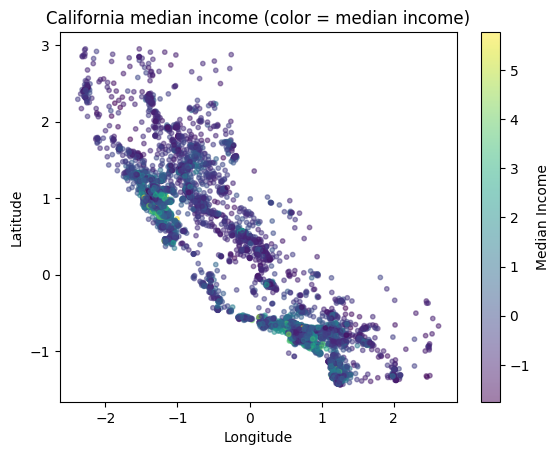

In [296]:
plt.scatter(train_df_scaled["longitude"], train_df_scaled["latitude"], c=train_df_scaled["median_income"], cmap="viridis", s=10, alpha=0.5)
plt.colorbar(label="Median Income")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("California median income (color = median income)")
plt.show()

We calculate the correlation matrix to select the features for the polynomial regression model

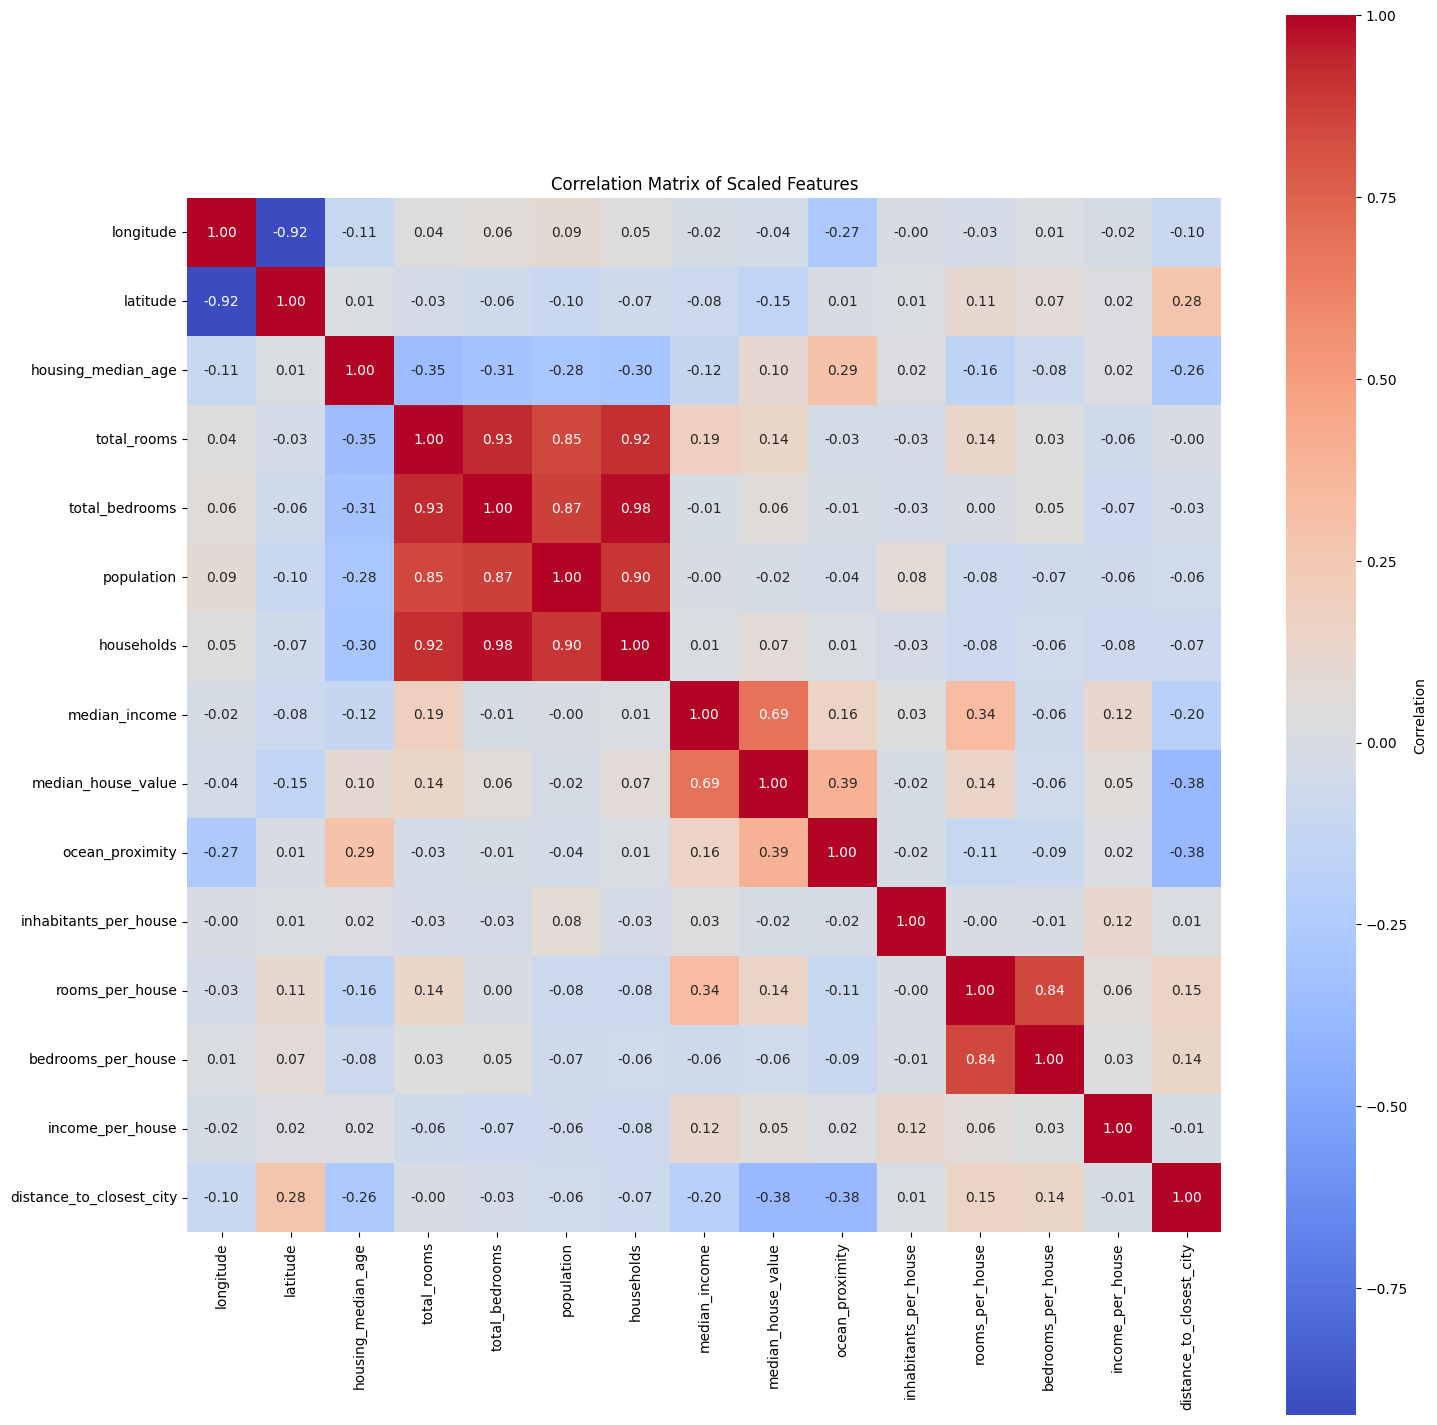

In [297]:
corr = train_df_scaled.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={'label': 'Correlation'})
plt.title('Correlation Matrix of Scaled Features')
plt.tight_layout()
plt.show()

The two features we will use are the median income and the distance to major city

In [298]:
train_df_poly = train_df_scaled[["median_income", "ocean_proximity", "median_house_value"]]

In [299]:
# Prepare features and target
X_train_poly = train_df_poly[["median_income", "ocean_proximity"]]
y_train_poly = train_df_poly["median_house_value"]

# Create polynomial features . We use a second degree polynomial
poly = PolynomialFeatures(degree=2, include_bias=True)
X_train_poly = poly.fit_transform(X_train_poly)
print(X_train_poly.shape)

# Fit the polynomial regression model
model = LinearRegression()
model.fit(X_train_poly, y_train_poly)
# Prepare test data
X_test_poly = test_df_scaled[["median_income", "ocean_proximity"]]
y_test_poly = test_df_scaled["median_house_value"]
X_test_poly = poly.transform(X_test_poly)
# Predict on test data
y_pred = model.predict(X_test_poly)
# Evaluate the model

(13036, 6)


In [300]:
# Inverse the standard scaling for better visualization
y_test_poly = inverse_scaling(y_test_poly)
y_pred = inverse_scaling(y_pred)

# Calculate Root Mean Squared Error (RMSE) and R^2 score
mse = mean_squared_error(y_test_poly, y_pred)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")
r2 = r2_score(y_test_poly, y_pred)
print(f"R^2 Score: {r2}")


Root Mean Squared Error: 74202.21824300285
R^2 Score: 0.5882818833982286


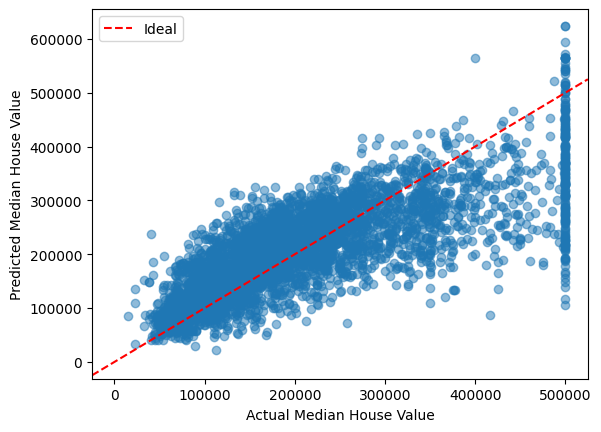

In [301]:
plt.scatter(y_test_poly, y_pred, alpha=0.5)
plt.xlabel("Actual Median House Value")
plt.ylabel("Predicted Median House Value")
plt.axline((0, 0), slope=1, color='red', linestyle='--', label='Ideal')
plt.legend()

The baseline model is a good start, but there is still room for improvement


**Feedforward neural network model** - Building and training

In [302]:
# Inputs and outputs
X_train_ANN = train_df_scaled.drop(columns=["median_house_value"])
X_validation_ANN = val_df_scaled.drop(columns=["median_house_value"])
y_train_ANN = train_df_scaled["median_house_value"]
y_validation_ANN = val_df_scaled["median_house_value"]

In [303]:
# Define the feedforward neural network
class FeedforwardNN(nn.Module):
    def __init__(self, input_dim=X_train_ANN.shape[1], hidden_dim_1=32, hidden_dim_2=16, output_dim=1, dropout_rate=0.2):
        super(FeedforwardNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim_1),
            nn.ReLU(),
            nn.Linear(hidden_dim_1, hidden_dim_2),
            nn.ReLU(),
            nn.Linear(hidden_dim_2, hidden_dim_2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim_2, output_dim)
        )

    def forward(self, x):
        return self.model(x)


In [304]:
def build_train_model(X_train, y_train, X_validation, y_validation,
        hidden_dim_1=32, hidden_dim_2=16, dropout_rate=0.2,
        epochs=500, batch_size=64, learning_rate=0.001, patience=30):
    
    # Build the model
    model_nn = FeedforwardNN(hidden_dim_1=hidden_dim_1, hidden_dim_2=hidden_dim_2, dropout_rate=dropout_rate)

    # DataLoader for batching
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Model, optimizer, scheduler, loss
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_nn = model_nn.to(device)
    criterion = nn.MSELoss() # Mean Squared Error for regression
    optimizer = optim.Adam(model_nn.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

    # Early stopping variables
    best_loss = float('inf')
    epochs_no_improve = 0
    losses = []

    for epoch in range(epochs):
        model_nn.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model_nn(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        scheduler.step(epoch_loss)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.6f}")

        # Evaluate on validation set
        model_nn.eval()
        with torch.no_grad():
            val_outputs = model_nn(X_validation.to(device))
            val_loss = criterion(val_outputs, y_validation.to(device))
            print(f"Validation Loss: {val_loss.item():.6f}")

        # Early stopping
        if val_loss.item() < best_loss:
            best_loss = val_loss.item()
            epochs_no_improve = 0
            best_model_state = model_nn.state_dict()
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping triggered.")
                model_nn.load_state_dict(best_model_state)
                break
        
        # Store training and validation loss for each epoch
        losses.append([epoch_loss, val_loss.item()])

  
    # Save the trained neural network model
    model_name = f"trained_housing_nn_{hidden_dim_1}_{patience}_{batch_size}"
    torch.save(model_nn, os.path.join("models" ,
                                f"trained_housing_nn_{hidden_dim_1}_{patience}_{batch_size}.pth"))
    losses = np.array(losses)
    np.save(os.path.join("models", f"losses_housing_nn_{hidden_dim_1}_{patience}_{batch_size}.npy"), losses)
    return model_name, losses


**Hyperparameter tuning**

In this section, some parts are commented off because the neural networks were already trained

In [305]:
X_train_tensor = torch.tensor(X_train_ANN.values, dtype=torch.float32)
X_validation_tensor = torch.tensor(X_validation_ANN.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_ANN.values, dtype=torch.float32).unsqueeze(1)
y_validation_tensor = torch.tensor(y_validation_ANN.values, dtype=torch.float32).unsqueeze(1)


hidden_dim_1_option = [8,16]
patience_option = [20, 30]
batch_size_option = [16, 128]

param_combinations = [[h1, p, bs] for h1, p, bs in product(hidden_dim_1_option, patience_option, batch_size_option)]
print(param_combinations)


# We create a dictionary to store the losses, rmse and r2 for each model
dict_of_model_perf_indicators = {}

# Iterate through all combinations of hyperparameters
# and train the model for each combination
# Save the model name and losses in a dictionary
# This will allow us to later analyze the performance of each model

# UNCOMMENT THE FOLLOWING CODE TO TRAIN THE MODELS AGAIN
"""
for params in param_combinations:

    model_name, model_losses = build_train_model(X_train=X_train_tensor, y_train=y_train_tensor, X_validation=X_validation_tensor, y_validation=y_validation_tensor,
                      hidden_dim_1=params[0], hidden_dim_2=16, dropout_rate=0.2,
                      epochs=300, batch_size=params[2], learning_rate=0.001, patience=params[1])

    dict_of_model_perf_indicators[model_name] = {"losses": model_losses}

pkl.dump(dict_of_model_perf_indicators, open("dict_of_models.pkl", "wb"))

"""

[[8, 20, 16], [8, 20, 128], [8, 30, 16], [8, 30, 128], [16, 20, 16], [16, 20, 128], [16, 30, 16], [16, 30, 128]]


'\nfor params in param_combinations:\n\n    model_name, model_losses = build_train_model(X_train=X_train_tensor, y_train=y_train_tensor, X_validation=X_validation_tensor, y_validation=y_validation_tensor,\n                      hidden_dim_1=params[0], hidden_dim_2=16, dropout_rate=0.2,\n                      epochs=300, batch_size=params[2], learning_rate=0.001, patience=params[1])\n\n    dict_of_model_perf_indicators[model_name] = {"losses": model_losses}\n\npkl.dump(dict_of_model_perf_indicators, open("dict_of_models.pkl", "wb"))\n\n'

In [306]:
# Prepare test data for ANN (drop target column)
X_test_ANN = test_df_scaled.drop(columns=["median_house_value"])
y_test_ANN = test_df_scaled["median_house_value"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Convert to torch tensor
X_test_tensor = torch.tensor(X_test_ANN.values, dtype=torch.float32).to(device)


def evaluate_model_performance(model_path, X_test, y_test):
    """
    Evaluate the performance of the trained models on the test set.
    """
    print(model_path)
    model_nn = torch.load(model_path, weights_only=False)  # Model with smallest validation loss selected
    # Set model to evaluation mode and predict
    model_nn.eval()
    with torch.no_grad():
        y_pred_ANN = model_nn(X_test).cpu().numpy().flatten()

    # Inverse the standard scaling for better visualization
    y_test_ANN_rescaled = inverse_scaling(y_test)
    y_pred_ANN_rescaled = inverse_scaling(y_pred_ANN)

    # Calculate Root Mean Squared Error (RMSE)
    mse_ANN = mean_squared_error(y_test_ANN_rescaled, y_pred_ANN_rescaled)
    rmse_ANN = np.sqrt(mse_ANN)
    r2_ANN = r2_score(y_test_ANN_rescaled, y_pred_ANN_rescaled)
    return rmse_ANN, r2_ANN, y_test_ANN_rescaled, y_pred_ANN_rescaled

"""
for model in dict_of_model_perf_indicators.keys():
    model_path = os.path.join("models", f"{model}.pth")

    print(f"Evaluating model: {model}")
    rmse_ANN, r2_ANN, y_test_ANN_rescaled, y_pred_ANN_rescaled = evaluate_model_performance(model_path, X_test_tensor, y_test_ANN)
    print(f"RMSE: {rmse_ANN:.2f}, R^2: {r2_ANN:.2f}")
    print("-" * 50)
    dict_of_model_perf_indicators[model]["rmse"] = rmse_ANN
    dict_of_model_perf_indicators[model]["r2"] = r2_ANN
"""


'\nfor model in dict_of_model_perf_indicators.keys():\n    model_path = os.path.join("models", f"{model}.pth")\n\n    print(f"Evaluating model: {model}")\n    rmse_ANN, r2_ANN, y_test_ANN_rescaled, y_pred_ANN_rescaled = evaluate_model_performance(model_path, X_test_tensor, y_test_ANN)\n    print(f"RMSE: {rmse_ANN:.2f}, R^2: {r2_ANN:.2f}")\n    print("-" * 50)\n    dict_of_model_perf_indicators[model]["rmse"] = rmse_ANN\n    dict_of_model_perf_indicators[model]["r2"] = r2_ANN\n'

In [307]:
# This cell is to plot the RMSE and R2 of the different models, uncomment if needed

"""
model_names = list(dict_of_model_perf_indicators.keys())
r2_scores = [dict_of_model_perf_indicators[m]['r2'] for m in model_names]
rmse_scores = [dict_of_model_perf_indicators[m]['rmse'] for m in model_names]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# R2 subplot
axs[0].bar(model_names, r2_scores, color='skyblue')
axs[0].set_title('R² Score by Model')
axs[0].set_ylabel('R² Score')
axs[0].set_xticklabels(model_names, rotation=45, ha='right')

# RMSE subplot
axs[1].bar(model_names, rmse_scores, color='salmon')
axs[1].set_title('RMSE by Model')
axs[1].set_ylabel('RMSE')
axs[1].set_xticklabels(model_names, rotation=45, ha='right')

plt.tight_layout()
"""

"\nmodel_names = list(dict_of_model_perf_indicators.keys())\nr2_scores = [dict_of_model_perf_indicators[m]['r2'] for m in model_names]\nrmse_scores = [dict_of_model_perf_indicators[m]['rmse'] for m in model_names]\n\nfig, axs = plt.subplots(1, 2, figsize=(12, 5))\n\n# R2 subplot\naxs[0].bar(model_names, r2_scores, color='skyblue')\naxs[0].set_title('R² Score by Model')\naxs[0].set_ylabel('R² Score')\naxs[0].set_xticklabels(model_names, rotation=45, ha='right')\n\n# RMSE subplot\naxs[1].bar(model_names, rmse_scores, color='salmon')\naxs[1].set_title('RMSE by Model')\naxs[1].set_ylabel('RMSE')\naxs[1].set_xticklabels(model_names, rotation=45, ha='right')\n\nplt.tight_layout()\n"

## Section summary

- Two models were trained to predict the median housing costs
    - 2nd degree polynomial regressor:
        - Inputs: Ocean proximity and median income
        - Results on the test set: **RMSE: 74 k / R2 : 0.59**
    - Feedforward neural network:
        - Some characteristics:
            - Activation function: ReLU
            - Loss function: MSE
            - Dropout layer included
            - Early stopping included
            - Scaling: StandardScaler
        - Inputs: All the features described in the previous section
        - Hyperparameter tuning was performed using the grid search method 
            - Tuned parameters - Batch size, early stop criterium and layer size
            - Hyperparameter tuning did not affect the results significantly
        - Results on the test set (approximately the same for all models): **RMSE: 50 k / R2 : 0.8**


## 6) Assessing the accuracy of the model

final_model/trained_housing_nn_16_30_128.pth
RMSE: 50672.73, R^2: 0.81


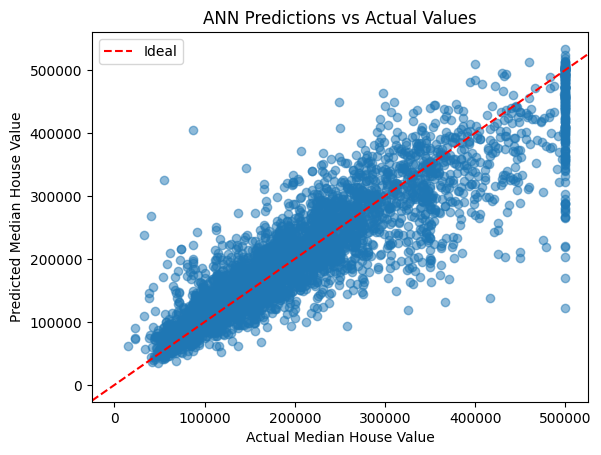

In [308]:
selected_model = os.path.join("final_model", "trained_housing_nn_16_30_128.pth")
rmse_ANN, r2_ANN, y_test_ANN_rescaled, y_pred_ANN_rescaled = evaluate_model_performance(selected_model, X_test_tensor, y_test_ANN)

plt.scatter(y_test_ANN_rescaled, y_pred_ANN_rescaled, alpha=0.5)
plt.xlabel("Actual Median House Value")
plt.ylabel("Predicted Median House Value")
plt.axline((0, 0), slope=1, color='red', linestyle='--', label='Ideal')
plt.legend()
plt.title("ANN Predictions vs Actual Values")

print(f"RMSE: {rmse_ANN:.2f}, R^2: {r2_ANN:.2f}")

# 7) Using the model

Here we create a simple function to use the model

In [309]:
def predict_house_value(model_path, longitude, latitude, housing_median_age, total_rooms, total_bedrooms,
                        population, households, median_income, ocean_proximity):
    """
    Predict the median house value of one neighborhood using the trained model.
    Args:
        model_path (str): Path to the trained model.
        longitude (float): Longitude of the neighborhood.
        latitude (float): Latitude of the neighborhood.
        housing_median_age (int): Median age of the housing in the neighborhood.
        total_rooms (int): Total number of rooms in the neighborhood.
        total_bedrooms (int): Total number of bedrooms in the neighborhood.
        population (int): Population of the neighborhood.
        households (int): Number of households in the neighborhood.
        median_income (float): Median income of the neighborhood.
        ocean_proximity (int): Ocean proximity (ordinal value).
    """
    # Check for negative values in inputs except longitude
    input_values = [latitude, housing_median_age, total_rooms, total_bedrooms, population, households, median_income, ocean_proximity]
    if any(val < 0 for val in input_values):
        raise ValueError("Input values (except longitude) must not be negative.")
    
    # Check if longitude and latitude are within California bounds
    if not (-124.5 < longitude < -113.9):
        raise ValueError("Longitude must be within the range of California (-124.5 to -113.9).")
    if not (32.5 < latitude < 42.01):
        raise ValueError("Latitude must be within the range of California (32.5 to 42.01).")
    
    # Pending: Make a more accurate assesment of the whether the location is in California - use a polygon

    # Calculate additional features
    inhabitants_per_house = population / households
    rooms_per_house = total_rooms / households
    bedrooms_per_house = total_bedrooms / households
    income_per_house = median_income / households
    minimal_distance_to_city = float('inf')

    for key, (lon, lat) in cities.items():
        distance_to_city = haversine((latitude, longitude), (lat, lon))
        if distance_to_city < minimal_distance_to_city:
            minimal_distance_to_city = distance_to_city
    # Prepare the input data - the 0 is a placeholder for the median_house_value
    input_data_scaler = [
        longitude, latitude, housing_median_age, total_rooms, 
        total_bedrooms, population, households, median_income, 0, 
        ocean_proximity, inhabitants_per_house, rooms_per_house, 
        bedrooms_per_house, income_per_house, minimal_distance_to_city
    ]
    # Scale the input data using the same scaler as training
    input_data_scaled = scaler.transform([input_data_scaler])
    input_data = np.delete(input_data_scaled,8)
    model_nn = torch.load(model_path, weights_only=False)
    model_nn.eval()
    
    # Convert input data to tensor
    input_tensor = torch.tensor(input_data, dtype=torch.float32).unsqueeze(0)
    with torch.no_grad():
        prediction = model_nn(input_tensor).cpu().numpy().flatten()
    
    # Inverse scaling
    prediction_rescaled = inverse_scaling(prediction[0])
    
    return prediction_rescaled

In [310]:
pr = predict_house_value(selected_model, 
    longitude=-122.23, latitude=37.88, housing_median_age=41, total_rooms=880, total_bedrooms=129, 
    population=322, households=126, median_income=8.3252, ocean_proximity=0.75) # this is a knonw example from the dataset


/home/marcelo/miniconda3/envs/housing/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [311]:
pr

np.float64(410236.6399380195)

## 7) Final remarks and next steps

- The ANN model tends to perform better with the less expensive houses, which is expected given that they are much more less expensive households (see df.describe at the start)
- As expected, the houses costing 500k were hard for the model to predict.

### Potential next steps

- Use the residuals (actual - prediction) to make model more accurate, e.g. by training a model on the residuals, an interesting option to explore would be a GPR
- Analyze other ways of converting "proximity to ocean" to numeric values, instead of ordinal
- Model fine tuning did not change the outcomes drastically, focus more on preprocessing 
- Add more performance metrics (e.g. MAE)
- Test other types of models - something more versatile than a polynomial regressor but less complex than a neural network
- Make the prediction function more robust to errors
- Adjust the prediction function accept an array of inputs instead of one at a time
